# OPTION 1. A day in the life of a Minervan Part III

# 1. Utility calculation

Throughout this assignment, I will consistently define my optimization objective as to maximize the cumulative profit gained from scheduled tasks. This is reflected through the use of utility value: the higher the utility value of a task have, the higher the chance that task got scheduled. However, due to multiple constraints such as the scheduler has to end in 24 hours, tasks must be executed after its dependencies all have been scheduled, the highest utility task will not necessarily being chosen. 

The utility calculation should also reflect/ have an effect on how tasks dependency are handled.

a. The formula will give fixed tasks with sooner start time a higher utility. So tasks that start sooner will be popped out first in order because they are the root of the Max heap. I confirm that the output did give higher utility for task starts at 7AM than task starts at 10AM (3.4 vs 2.4)

b. For flexible tasks:
+ The formula makes sure that task with fewer numbers of dependencies (by using exponential decay) and with longer duration will be prioritized. This serves 2 purposes (1) to ensure that the tasks that are most likely to block other tasks are completed first, which allows other tasks to be pushed into either heaps when dependencies are removed; and (2) Tasks with longer duration are assumed to be more important, and starting them earlier gives you more flexibility in scheduling the remaining tasks. If a long task is left until the end, it might delay the entire schedule.

    + This formula also prioritize dependency more than task duration. That's mean a task with higher duration but with higher dependency as well, will be deprioritized compared to a task with shorter duration but also fewer dependencies. Dependency is prioritized because its consequence on the flow of other tasks is much more severe, as stated above.

- This is ensured by using exponential decay: 
For example, let's hypothetically consider task 1 with (no_depdnency = 10, duration = 30) and task 2 with (no_dependnency = 3, duration = 5)
    + Without exponential decay: task 1's utility = 1/10 * 30 = 3 & task 2's utility = 1/3 * 5 = 1.7
-> Task 1 will be prioritized while having more dependencies than task 2
    + With exponential decay: task 1's utility = e^(-10) * 30 = 0.0013 & task 2's utility = e^(-3) * 5 = 0.25
-> Task 2 will be prioritized


- The utility calculation also gives higher weight for tasks that are prerequites for fixed task. The find_all_dependencies() method recursively finds all dependencies, both direct and indirect, for fixed tasks. So all tasks that are either direct or direct prerequites for fixed tasks will yield higher utility to ensure all the prerequisites for fixed tasks are done before the start time of the fixed task, thus ensuring fixed tasks are executed on time.

        for task in self.tasks:
            if task.start_time is not None:
                direct_dependencies_of_fixed_tasks.update(task.dependencies)
                # Recursively find all dependencies
                self.find_all_dependencies(task, all_dependencies_of_fixed_tasks)

        # Calculate utility for each task
        for task in self.tasks:
            if task.start_time is not None:
                task.utility = 1 / (task.start_time  / 60)
            else:
                # Base utility on direct dependencies only
                task.utility = math.exp(-len(task.dependencies)) * (1/10 * task.duration / 60)

                # Increase utility if the task is a direct or indirect prerequisite for a fixed task
                if task.id in all_dependencies_of_fixed_tasks:
                    task.utility *= 10


# 2. Review algorithm

### Assumptions and limitations:

The most notable limitation of the first Scheduler is that Heaps/ Priority queue only look at the current choice without having a bigger picture about the entire task list in order to make optimization about what task should be chosen at the moment. This is because we leverage the best advantage of Heap with its ability to peek at the root in O(1) time but requires a full sorting procedure for finding elements that aren't the max or traversing and returning an ordered list, thus we disregard other constraints might appear in other tasks behind. For example, choosing the highest priority task accidently takes so much time due to long duration and take away the ability to fit other tasks in the remaining time, while this root's priority is not significantly higher than others. 

### How might we improved

A simple improvement on this would be to get the next 3 or 4 priority tasks (presuccessor/ sucsessors) instead of just finding the max/min in order to get more long-term view. For example, comparing heap and Red Black Tree, we see that RBTs are typcically better than heaps for applications where balance is NB (large inputs, frequent searching/inserting). Also, RBTs allow traversal where heaps are better for retrieving min/max, so we might use RBT for finding any element (ie median) but heap for finding BEST element (ie high priority task). For example, we discussed the applicability of using heaps in tracking the most trending videos by using utilities such as number of views and likes, while RBT can be useful for maintaining a dynamic dataset such as contact management apps that categorize contacts alphabetically and allows for querying, inserting and deleting a contact.

**Word count**: 277 words

# 3. Multitasking

### Define objective of multitasking

- Optimization: The multitasking must adhere to the original objective optimization, which is to maximize the cumulative priority. Therefore, the choice of whether we executed fixed task, non-multitaskabe flexible task or mutitaskable flexible task will still depend on the task's utility score. For example, the compatable task we choose to multitask with must be chosen as the highest priority one among all of the multitaskable tasks
- Feasibility: Since there will be multiple multitaskable tasks that can be run simultaniously, we must set a constraint on how many tasks should we fit in the multitask interval. I decided not to put much mental pressure on users, so only 2 tasks can be multitasked at the same time. I will keep one single main multitaskable task and schedule other compatible multitaskable tasks on the main one's spot. The added one must (1) be compatible with the main one, (2) must have its dependencies already executed, and (3) has shorter duration than the main one. The criteria 3 is to make sure that we do not delay the main multitaskable task by possibly, too many low-priority multitaskable tasks. For example, we have non-multitasable task A with priority = 5 and multitaskable task B = 6. We execute task B simultaniously with task C, task D... with priority only 0.5. We would want to make sure that total duration of those compatiple tasks does not exceed task B, because we don't those low-priority tasks to delay the more important task A, cause task A is non-multitaskable.

### Justify choice of the third priority queue

We achieve the optimization objective by handling 3 priority queues to efficiently manage tasks based on their priorities: fixed tasks queue, flexible tasks queue, and multitaskable tasks queue. While fixed task must be executed at the designated time, the choice of whether to execute flexible task or multitaskable tasks must be depended on which one has higher utility. This constraint explains why we manage multitaskable tasks in a priority queue, because we can quickly peek at the root of both flexible tasks queue and multitaskable tasks queue to choose which one is higher. 

### Conceptual design

1. Initialization: Set the current time to the start time of the schedule and initialize a variable for total utility.

2. Calculate Utility: Call the calculate_utility method to calculate the utility of each task based on the defined rules.

3. Task Execution Loop: Continue executing tasks while there is still time and there are tasks to execute. The loop considers tasks in the fixed task queue, flexible task queue, and multitask queue, prioritizing tasks based on their utility.

4. Fixed Task Execution: If there are only fixed tasks, execute the task with the highest priority (earliest fixed task time) from the fixed task queue. Check if there is enough time to complete the task; if not, end the schedule.

5. Break Before Fixed Task: If there are both fixed tasks and tasks in other queues, and there is not enough time to complete a flexible or multitaskable task before the fixed task starts, take a break until the fixed task starts.

6. Flexible Task Execution: If there are only flexible tasks or they have higher utility than multitaskable tasks, execute the flexible task with the highest priority.

7. Multitaskable Task Execution: If there are only multitaskable tasks or they have higher utility than flexible tasks, execute multitaskable tasks. Multitasking is allowed if the tasks are compatible and duration satisfying.  We multitask by keep adding the compatible tasks into the original time slot. For example, the original multitaskable task O's duration is 10, so we can simultaniously executed task A (duration = 4), then task B (duration = 6)
- Compatable: task A and task B are compatible with task O and compatibale with each other
- Compatbale duration: the total duration of task A and B does not exceed the duration of task O or the next fixed task time.

8. Completion and Output: After task execution, update the current time, total utility, task statuses and remove dependency as the first scheduler. Print output messages based on the execution.

# 4. 1. Dynamic programming

This problem can be executed as an adapted multiple 0/1 Knapsack problem. Consider the task as an item, with weight = duration and profit = task utility. Since tasks cannot overlapping and not splittable, this resembles the way we choose to include/ not included the task.
This is an optimization problem in which we do not always choose the highest priority task at the current time, instead, a solution to a subproblem will be dependent on what are the solutions to other subproblems. Therefore, the use of priorty queue is not suitable because it always just look at the highest priority task at one point at a time

### Optimal substructure:

The optimal solution to the overall problem can be constructed from optimal solutions to its subproblems.
- Since fixed task will always be executed at their designated start time, there is no need to including them in the optimization problem. however, fixed task can serve to partition the overal problem into subproblems: the interval between 2 fixed tasks.
- We have multiple intervals as multiple subproblems. We already know that fixed tasks are static, so those intervals (subproblems) are static as well. So the global optimal solution must include the optimal partitioning of the interval, and the optimal partitioning of subsequent intervals that follow. 
- Once a task has been found to be optimally in one interval, we know that it cannot be in any other interval since tasks are not splittable. Therefore, we can solve each interval independently. Once we got the local optimal solution to each interval, we know that the combination of those local optimal solution of each interval, alongside with the designated fixed tasks will make up the global optimal solution. 

### Overlapping subproblems:

Inside each interval, the overlapping subproblems arise when we consider whether to include a task or not. We will compare the accumulate utility from including and excluding task. The utility of including the task will be the utility of the task and the accumulate utlity of the remaining space to schedule other task. Since the remaining value is in turn, built upon by consider whether to including the compatible task (the task can be schedule within the remaining time after scheduling the original task) and excluding it. We can observe that there are a lot of recalculation of utility value, thus a bottom up approach DP is needed to store the calculated value and reuse it when recountering

## Conceptual design

### Overall
Calculate Utility: self.calculate_utility() is invoked to compute utility values for each task based on their dependencies.

Interval Division: The method self.dynamic_programming_intervals() divides the tasks into intervals. For each task with a fixed start time, an interval is created between the previous task's end time and the current task's start time. This results in a list of intervals containing tasks and their respective start times and durations.


Optimal Order Determination: The algorithm iterates over each interval. If an interval is a tuple (indicating a fixed time interval), it invokes self.dynamic_programming_within_interval to determine the optimal order of tasks within that interval. The results are then appended to the final schedule.

### DP - two-step dynamic programming approach:

-  Utility Calculation:

The calculate_utility method assigns utility values to tasks, considering their dependencies. The utility is based on an exponential decay function, with an additional boost for tasks that are dependencies for fixed-time tasks.
- Topological Sorting:

The topological_sort method performs a topological sort on the tasks (using directed graph to represent dependency relationship between 2 tasks) providing an order that respects task dependencies.
- Interval Division:

The dynamic_programming_intervals method divides the tasks into intervals, where each interval contains tasks with fixed start times and flexible tasks without fixed start times.
- Dynamic Programming Within Interval:

The dynamic_programming_within_interval method optimally orders tasks within each interval using dynamic programming. It considers task dependencies, durations, and the specified time constraint.
- Two-Step Dynamic Programming:

The two_step_dynamic_programming method orchestrates the overall scheduling process. It calculates utility, divides tasks into intervals, and determines the optimal order within each interval using dynamic programming. The final schedule is a list of tasks in the optimized order.
2. DP_Dynamic_Utility_Scheduler Class:

This child class extends DynamicProgrammingScheduler and introduces dynamic utility calculation:

- Utility Adjustment:

The calculate_updated_utility method adjusts the utility calculation for each task based on whether its dependencies are satisfied. If dependencies are satisfied, the task's utility remains unchanged; otherwise, it is set to zero.
- Overridden Dynamic Programming Within Interval:

The dynamic_programming_within_interval method is overridden to utilize the updated utility calculation during dynamic programming. It ensures that task utilities are considered dynamically within each interval.

# 4.2. Greedy algorithm

Keeping the same optimization objective, we want to optimize the cumulative utility value from scheduled tasks. however, this is not simple as choosing the highest priority task at each choice because we have a time limit constraint so duration is also a consideration. For example, if we greedily choose highest priority tasks but with  small duration, we have remaining space left but we are not able to fit any task in because the remaining unchosen tasks are long-duration. This wasted space is the reason why the combination of sub-solutions is not closest approximation of the global optimal solution because we know that with different ordering, there wil be an inclusion of an unconsidered task that can be filled into that wasted empty space and increase the found cumulative utility, thus violating our assumption before that the combination has already combined into the global optimal solution. 


Therefore, I use the ratio of utility/ duration to order the tasks. The higher the utility and the shorter the duration of a task is, the earlier the task will be scheduled. We prioritize higher utility tasks because we know that a global optimal solution will try to include all of high utility tasks, thus the chosen of the highest utility task greedily will be safe as we are left with the remaining space with a local optimal solution by keep choosing the next highest utility tasks. A shorter duration task will be prioritized because we know that a global optimal solution will try to include as many tasks as possible, so shorter duration will leave more space to schedule more the maximal number of tasks. 

As explain before, we know that the optimal global solution will contain the fixed task and static intervals between those fixed tasks. Therefore, the optimal substructure is emplyed again in the greedy algorithm by partitioning the day into multiple intervals and use greedy algorithm to optimize task ordering in each interval. The combination of local optimal ordering in each interval will combine into a global solution. However, as we only look at current choice, there is not guarantee that the obtained global solution is the optimal global solution 

### Conceptual design

- Utility Calculation:

The calculate_utility method calculates the utility for each task based on direct and indirect dependencies. The utility is updated, with a factor of 10 applied to tasks whose dependencies are satisfied, and a factor of 1 for tasks with unsatisfied dependencies.
- Interval Division:

I reuse the dynamic_programming_intervals method to divides the tasks into intervals, where each interval contains tasks with fixed start times and flexible tasks without fixed start times.

- Greedy Scheduling Algorithm Within Interval:

The greedy_algorithm_schedule method performs the actual scheduling using a greedy approach on the intervals obtained from the dynamic_programming_intervals method.
For each interval, tasks are sorted in descending order based on the ratio of utility to duration and respect the dependency by the use of topological sorting (reuse from dynamic programming). This sorting is a crucial step in the greedy algorithm as it prioritizes tasks with higher utility-to-duration ratios.
Tasks within an interval are then scheduled in the order determined by the sorting. The algorithm considers the utility, duration, and dependencies of each task during scheduling.
- The final schedule is a list of tasks ordered by the greedy algorithm.

### Test case:
Test case is provided in the appendix

# Time complexity

# Dynamic programming

### Theoretically:

The main operation in the dynamic programming approach is the use of the table that stores the utility of task. The column will be n number of tasks and the row will be duration of the intervals, which is dependent on the number of fixed time tasks in the task list. If there are 3 fixed task, the number of intervals will be 4 and the average duration of each interval will the the total duration/ 4 -> thus the number of column and row will be dependent on the number of tasks and the number of fixed tasks, which will all be boied down to n when talking to asymtotic runtime. 


__init__ Function:

Time Complexity: O(1)
The initialization function has constant time complexity, as it performs basic assignments and does not depend on the size of the input.
calculate_utility Function:

Time Complexity: O(T * D)
T: Number of tasks, D: Maximum number of dependencies for a task
The function iterates through all tasks to calculate utility, and for each task, it may iterate through its dependencies. In the worst case, it is proportional to the product of the number of tasks and the maximum number of dependencies for a single task.
find_all_dependencies Function:

Time Complexity: O(D), where D is the number of dependencies for the given task
The function performs a depth-first search (DFS) to find all dependencies of a task. In the worst case, it is proportional to the number of dependencies for the task.
find_task_by_id Function:

Time Complexity: O(T), where T is the number of tasks
The function iterates through all tasks to find and return a task based on its ID.
topological_sort Function:

Time Complexity: O(T + D), where T is the number of tasks, D is the total number of dependencies across all tasks
The function performs a topological sort using depth-first search (DFS). It iterates through all tasks and dependencies.
dynamic_programming_intervals Function:

Time Complexity: O(T log T), where T is the number of tasks
The function sorts tasks topologically, which takes O(T log T) time using depth-first search (DFS) for topological sorting.
dynamic_programming_within_interval Function:

Time Complexity: O(N * M), where N is the number of tasks in the interval, M is the duration of the interval
The function uses dynamic programming to schedule tasks within an interval. The time complexity is proportional to the product of the number of tasks in the interval and the duration of the interval.
two_step_dynamic_programming Function:

Time Complexity: O(T * (T + D) + T log T + N * M), where T is the number of tasks, D is the total number of dependencies across all tasks, N is the number of intervals, M is the maximum duration of an interval
The function calls other functions with their respective time complexities.

## Experiment

As explained, the way the table is constructed is depended on how many intervals it is (will determine the duration of each interva thus the number of t (column) of the table). Therefore, I generated 3 test cases: 1 average case with random input, one case will all_fixed_task input (n intervals) and no_fixed_task_input (0 interval or interval duration - tota scheduler duration)

Both 3 approaches give the same graph with approximate runtime scaling of n^2. Test point. When n = 1000, runtime approximates 0.02s and when n doubles (n = 2000), the runtime goes to 0.08, which 4 times. Therefore the approximate asymtotic scaling of the algorithm is approximately O(n^2)

In line with the theoretical complexity above, Time Complexity: O(T * (T + D) + T log T + N * M), it is reasonable since O(n^2 + n*logn + n*m) will be dominated by O(n^2)

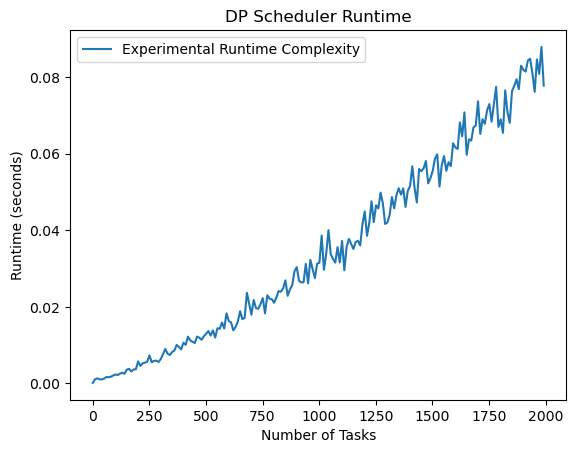

## Greedy algorithm

### Theoretical

calculate_utility() function:

In the worst case, it iterates over all tasks twice: once to find direct and all dependencies and once to update the utility based on dependencies.
The for loop that iterates over tasks has a time complexity of O(n), where n is the number of tasks.
The find_all_dependencies function, in the worst case, can visit all dependencies, leading to a time complexity of O(m), where m is the total number of dependencies across all tasks.
Overall, the time complexity of calculate_utility() is O(n + m).
greedy_algorithm_schedule() function:

The function iterates over intervals and sorts tasks in each interval based on a key function.
Sorting has an average time complexity of O(k log k), where k is the number of tasks in an interval.
The overall time complexity of the greedy_algorithm_schedule() function is dominated by the sorting step and can be expressed as O(I * K log K), where I is the number of intervals and K is the maximum number of tasks in an interval.
Considering the two main steps together, the overall time complexity of the entire greedy algorithm is approximately O(n + m + I * K log K), where n is the number of tasks, m is the total number of dependencies, I is the number of intervals, and K is the maximum number of tasks in an interval.

### Experimental

Testing by the same 3 test cases, I received the same runtime scaling of O(n^2), which correspond to the case that O(n + m + I * K log K) is dominated by O(I * K log K).  
Test point: When n = 1000, runtime approximates 0.01s and when n doubles (n = 2000), the runtime goes to 0.05, which approximates 4 times. Therefore the approximate asymtotic scaling of the algorithm is approximately O(n^2)

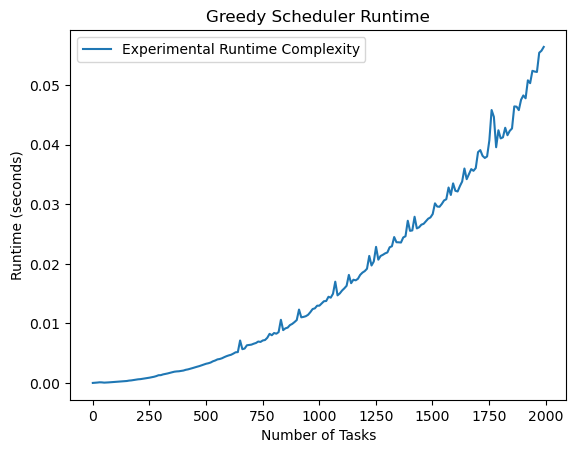

## Multitasking DP

To modify your current dynamic programming algorithm to support multitasking, you can introduce the concept of multitasking intervals and update the algorithm to consider the simultaneous execution of tasks within those intervals. Here's a step-by-step guide:

1. Identify Multitasking Opportunities:
Define Multitasking Capable Tasks:
Identify tasks that can be multitasked with others. This information can be added as an attribute to your Task class. For example, you can have a multitask attribute that contains a list of task IDs that can be multitasked simultaneously with the current task.
2. Extend the Task Class:
Modify the Task Class:
Add a multitask attribute to the Task class. This attribute will contain the list of task IDs that can be multitasked simultaneously with the current task.

Adjust calculate_utility Method:
Update the calculate_utility method to consider multitasking. If a task is multitaskable, consider its utility in the context of simultaneous execution with other tasks.

            # Increase utility if the task can be multitasked
            if task.multitask:
                for multitask_id in task.multitask:
                    multitask_task = self.find_task_by_id(multitask_id)
                    if multitask_task:
                        task.utility += multitask_task.utility

Update dynamic_programming_within_interval Method:
Modify the dynamic_programming_within_interval method to consider multitasking opportunities during the dynamic programming process.


    for i in range(n + 1):
        for t in range(interval_duration + 1):
            if i == 0 or t == 0:
                table[i][t] = 0
            elif interval_tasks[i - 1].duration <= t:
                include_task = interval_tasks[i - 1].utility + table[i - 1][t - interval_tasks[i - 1].duration]
                
                # Check if multitasking is possible
                for multitask_id in interval_tasks[i - 1].multitask:
                    multitask_task = self.find_task_by_id(multitask_id)
                    if multitask_task and multitask_task.start_time is None:
                        include_task += multitask_task.utility

                exclude_task = table[i - 1][t]
                table[i][t] = max(include_task, exclude_task)
            else:
                table[i][t] = table[i - 1][t]

    optimal_order = []
    i, t = n, min(self.time_constraint, interval_duration)
    while i > 0 and t > 0:
        if table[i][t] != table[i - 1][t]:
            task = interval_tasks[i - 1]
            task.end_time = interval_start + t
            task.start_time = interval_start + t - task.duration
            optimal_order.insert(0, task)
            t -= task.duration
        i -= 1

    return optimal_order


## Multitasking Greedy

- Calculate Utility:

The algorithm starts by calculating the utility of each task based on direct and indirect dependencies, similar to the original greedy algorithm.
The utility calculation takes into account satisfied dependencies, where the utility of a task is increased by a factor of 10 if all its dependencies are satisfied.
- Dynamic Programming Intervals:

The algorithm performs topological sorting on the tasks to establish their order of execution.
It then divides the tasks into intervals, taking into consideration fixed start times.
Each interval is represented by a tuple containing tasks, start time, and duration.
- Multitasking Greedy Scheduling:

For each interval, the algorithm performs a greedy scheduling algorithm to determine the order in which tasks should be executed within that interval.
The tasks within an interval are sorted based on a key function that considers task utility and duration. This sorting step determines the order in which tasks are considered for scheduling.
The algorithm iterates through the sorted tasks and schedules them concurrently, updating their start and end times accordingly.
- Final Schedule:

The final schedule is a combination of tasks scheduled within each interval.

# Computational Critique

a. Do all three implementations use the same data structures?

No, the three implementations (greedy, dynamic programming, and LBA) do not use the same data structures.

Dynamic Programming Scheduler:

Uses a 2D table for dynamic programming within intervals.
Utilizes lists and tuples to represent intervals and the final schedule.
Greedy Scheduler:

Primarily uses lists and tuples for intervals and the final schedule.
Employs sorting based on utility and duration.
LBA (Largest Benefit Area) Scheduler:

Utilizes two priority queues (max heaps) for fixed and flexible tasks.
Fixed task queue prioritizes tasks based on the start time and utility.
Flexible task queue prioritizes tasks based on dependencies and duration.
b. Do these new formulations (greedy and dynamic-programming driven) address all the concerns raised in question 1?

The new formulations, both greedy and dynamic programming, address some of the concerns raised in question 1, but they have their own strengths and limitations.

Dynamic Programming Scheduler:

Addresses concerns related to optimal substructure and overlapping subproblems by employing dynamic programming.
Provides an optimal solution by considering all possible task combinations within intervals.
May become computationally expensive for large datasets due to its exhaustive nature.
Greedy Scheduler:

Addresses concerns by providing a heuristic solution with a focus on immediate gains (greedy choice).
It may not guarantee an optimal solution, and its effectiveness depends on the chosen heuristic.
Performs well in terms of efficiency and can handle large datasets

**Best strategy**:
The choice of the best strategy depends on the specific requirements and constraints of the scheduling problem. Each strategy—Dynamic Programming, Greedy, and LBA—has its own strengths and weaknesses, and the best strategy is context-dependent. Here are considerations for each strategy:

1. Dynamic Programming:

- Strengths:
Provides an optimal solution by considering all possible task combinations within intervals.
Guarantees the global optimum for problems with optimal substructure and overlapping subproblems.
- Weaknesses:
Computationally expensive for large datasets due to its exhaustive nature.
Time complexity can be high, especially for problems with a large number of tasks.
2. Greedy:

- Strengths:
Provides a heuristic solution quickly and efficiently.
Scales better for larger datasets compared to dynamic programming.
- Weaknesses:
Does not guarantee an optimal solution; the greedy choice may lead to suboptimal results.
May not perform well in scenarios where global optimization is crucial.
3. LBA (Largest Benefit Area):

- Strengths:
Efficient and effective heuristic solution.
Prioritizes tasks based on their benefit-to-area ratio.
Well-suited for real-time scheduling and situations with a large number of tasks.
- Weaknesses:
Heuristic nature means it may not always provide the optimal solution.
Highly dependent on the quality of the benefit-to-area ratio as a heuristic.

**Choosing the Best Strategy:**

- Optimality vs. Efficiency: If achieving the optimal solution is crucial, and computational resources are sufficient, Dynamic Programming might be the best choice. If efficiency and scalability are more critical, a heuristic approach like Greedy or LBA may be preferred.

- Real-time Constraints: For scenarios with real-time constraints and a need for quick decision-making, Greedy and LBA are more suitable due to their efficiency.

- Trade-off Considerations: Consider the trade-off between optimality and efficiency. Greedy and LBA provide faster results, but they might sacrifice optimality in some cases.

- Problem Characteristics: The nature of the scheduling problem, including task dependencies, urgency, and dataset size, plays a significant role in choosing the best strategy.

In summary, there is no one-size-fits-all answer. The best strategy depends on the specific goals, constraints, and characteristics of the scheduling problem at hand.

**Time complexity**
The graph for plotting 3 time complexity of 3 algorithms took too long to respond so I cannot output the graph. However, from prior analysis and the abovementioned analysis, the theoretical and experimental time complexity of 3 algorithms are all O(n^2). Theoretically, dynamic programming should be most computational expensive due to the fact that its consideration accross all possible solutions. However, due to the partitioning into different intervals, we have successfully decrease the size of the table (the number of column is decreasing inproportionally to the number of intervals). Therefore, the 3 algorithms are approximately similar in terms of asymtotic runtime. Therefore, the choice of dynamic programming would be best considering its closest approximation to the global optimum solution

# HCS and LOs

#CS110 - CodeReadability: I will make my code more organized and well-structured. If there is any repetitive pattern in code, group that into a function and recall that function again when needed. Also, name the function intuitively so that readers who are unfamiliar with my algorithm can know what I am trying to do just by reading the function name. For example, instead of naming the function check_task_condition(), I can directly name it as is_there_unscheduled_task()



#CS110 - AlgoStratDataStruct: I explicitly explain why each case follows/does not follow the property of each approach. Given the new problem of this assignment is to optimize the task scheduling (analogy - the time available as the knapsack, and the activity as the item that we can input to the scheduler), I wil explain why greedy/ dynamic programming is suitable to optimize the number of scheduled tasks but also adhering to the constraint of deadline, task overlapping, end time, etc. For example, a task with the highest utility score might not be chosen if its duration is too long, so the dynamic programming approach decides to schedule another 2 smaller duration tasks that have a higher sum of utility



#cs110_CodeReadability

Python code will be generated with a focus on clarity and readability. Variables will have meaningful and descriptive names, adhering to the snake_case naming convention. Functions will be well-commented, explaining the purpose and the logic behind each block of code. When errors are possible, such as scheduling conflicts due to fixed start times or dependency violations, the code will include error messages that are informative and guide the user toward resolution. The objective is to produce maintainable and understandable code that performs its intended function efficientl



#cs110_ComputationalCritique

compare the 2 algorithms in multiple aspects and scenarios, by producing different plots for different types of input like duplicated tasks, tasks with no dependency, etc). In this assignment, I plan to provide a comprehensive comparison of greedy and dynamic programming by producing plots for best, average, and worst-case input types for each strategy. This can help answer the question of "When can a greedy algorithm be applicable/ better than dynamic programming?" by referencing the performance of a greedy algorithm under its best-case scenario (for example, a greedy algorithm works well for the 0-1 knapsack problem when ordering of items are "highest value item with the lightest weight, so on"). Also, The relative merits, such as ease of implementation, computational efficiency, and optimality of the solution, will be weighed to determine the most suitable algorithm given the project's constraints.



#cs110_PythonProgramming

Python will be the primary programming language used to implement the scheduling algorithms and data structures. The code will be structured to allow clear comparison of algorithm performance, and when appropriate, Python's plotting libraries (like matplotlib or seaborn) will be utilized to visualize performance metrics and outcomes, such as schedules and their corresponding priority values. These visualizations will aid in understanding the efficiency and effectiveness of the different scheduling strategies employed.

#Optimization: I identified the optimization function which is to maximize the maximum cumulative utility. I use this to derive my recurrence relation for the DP table, which keep track of the optimal cumulative utility of the right bottom task, the final result of the DP process. In the greedy algorthm, I also optimize utility but in combination with task duration to ensure that the number of tasks can be scheduled will be optimized

#breakitdown: This HCs helps me apply dynamic programming and greedy algorithm by breaking the large problem into smaller subproblems that satisfy the algorithm property. Namely breaking down overlapping subproblems, making sure each subproblem possesses optimal solution, and making sure that the combination of optimal solutions to the subproblems will make the global optimal solution.


#utility: I will apply the utility calculation considering more context and scenario. For example, if the goal is to optimize so the utility can be defined as scheduling as many tasks as possible while still satisfying the constraint. The preference given to the task should reflect this optimization objective, such as giving more utility for tasks that is shorter, so it could end sooner and leaving more time for scheduling task. Moreover, the utility function could reflect the risk-averse behavior of Minerva students by prioritizing tasks with a deadline over the task with ideal task time such as lunch (e.g by delaying lunch is something comes up...)

# APPENDIX

## Heap

In [180]:
class MaxHeapq:
    """ 
    A class that implements properties and methods
    that support a max priority queue data structure

    Attributes
    ----------
    heap : arr
        A Python list where key values in the max heap are stored

    heap_size: int
        An integer counter of the number of keys present in the max heap
    """

    def __init__(self):
        """
        Parameters
        ----------
        None
        """
        self.heap = []
        self.heap_size = 0

    def left(self, i):
        """
        Takes the index of the parent node and returns the index of the left child node

        Parameters
        ----------
        i: int
          Index of parent node

        Returns
        ----------
        int
          Index of the left child node
        """
        return 2 * i + 1

    def right(self, i):
        """
        Takes the index of the parent node
        and returns the index of the right child node

        Parameters
        ----------
        i: int
            Index of parent node

        Returns
        ----------
        int
            Index of the right child node
        """
        return 2 * i + 2

    def parent(self, i):
        """
        Takes the index of the child node
        and returns the index of the parent node

        Parameters
        ----------
        i: int
            Index of child node

        Returns
        ----------
        int
            Index of the parent node
        """

        return (i - 1)//2

    def maxk(self):
        """
        Returns the highest key in the priority queue.

        Parameters
        ----------
        None

        Returns
        ----------
        int
            the highest key in the priority queue
        """
        return self.heap[0]

    def heappush(self, key):
        """
        Insert a key into a priority queue

        Parameters
        ----------
        key: int
            The key value to be inserted

        Returns
        ----------
        None
        """
        self.heap.append(float("-inf"))
        self.increase_key(self.heap_size, key)
        self.heap_size += 1

    def increase_key(self, i, key):
        """
        Modifies the value of a key in a max priority queue
        with a higher value

        Parameters
        ----------
        i: int
            The index of the key to be modified
        key: int
            The new key value

        Returns
        ----------
        None
        """

        if key < self.heap[i]:
            raise ValueError('new key is smaller than the current key')
        self.heap[i] = key
        while i > 0 and self.heap[self.parent(i)] < self.heap[i]:
            j = self.parent(i)
            holder = self.heap[j]
            self.heap[j] = self.heap[i]
            self.heap[i] = holder
            i = j

    def heapify(self, i):
        """
        Creates a max heap from the index given

        Parameters
        ----------
        i: int
            The index of of the root node of the subtree to be heapify

        Returns
        ----------
        None
        """
        l = self.left(i)
        r = self.right(i)
        heap = self.heap
        if l <= (self.heap_size-1) and heap[l] > heap[i]:
            largest = l
        else:
            largest = i
        if r <= (self.heap_size-1) and heap[r] > heap[largest]:
            largest = r
        if largest != i:
            heap[i], heap[largest] = heap[largest], heap[i]
            self.heapify(largest)

    def heappop(self):
        """
        Returns the largest key in the max priority queue
        and remove it from the max priority queue

        Parameters
        ----------
        None

        Returns
        ----------
        maxk
            the max value in the heap that is extracted
        """
        if self.heap_size < 1:
            raise ValueError('Heap underflow: There are no keys in the priority queue ')
        maxk = self.heap[0]
        self.heap[0] = self.heap[-1]
        self.heap.pop()
        self.heap_size-=1
        self.heapify(0)
        return maxk

    def __len__(self):
        """
        Get the size of the heap.


        Parameters
        ----------
        None

        Returns
        ----------
        int
            The size of the heap
        """
        return self.heap_size
    def peek(self):
        return self.heap[0]




## Task class

In [181]:
import random, copy, math
class Task:
    
    def __init__(self, id, description, duration, dependencies, start_time=None, \
                 multitask=None, utility=0, status='N'):
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.start_time = start_time  # None or fixed time of task
        self.multitask = multitask  # None or list of multitaskable-fit tasks
        self.utility = utility
        self.status = status
    
    def __lt__(self, other):
        """
        Compares two tasks based on their priority values.

        Args:
        - other (Task): Another task to compare to.

        Returns:
        - bool: True if this task's priority is less than the other task's priority.
        """
        if isinstance(other, Task):
            return self.utility < other.utility
        else:
            return False
        
    def __str__(self):
        return f"Task {self.id}: {self.description}, \
        Duration: {self.duration} mins, \
    Dependencies: {self.dependencies}, Start Time: {self.start_time}"
    


## Class Task Scheduler

In [182]:
class TaskScheduler:
    """
        Constructor for the TaskScheduler class

        Parameters
        ----------
        tasks: list
            A list of Task objects
        fixed_tasks_queue: MaxHeap object
            A max heap priority queue to store the fixed tasks
        flexible_tasks_queue: MaxHeap object
            A max heap priority queue to store the flexible tasks
        multitask_queue: MaxHeap object
            A priority queue to store the multitaskable task
    """

    def __init__(self, tasks, start_time, end_time):

        self.tasks = tasks
        self.flexible_tasks_queue = MaxHeapq()
        self.fixed_tasks_queue = MaxHeapq()
        self.multitask_queue = MaxHeapq()
        self.start_time = start_time
        self.end_time = end_time
        self.completed_tasks = []
        self.still_time = True
    
    NOT_STARTED = 'N'
    IN_PRIORITY_QUEUE = 'I'
    COMPLETED = 'C'
    PRINT_OUTPUT = True  # Default value, can be changed as needed

    @classmethod
    def set_print_output(cls, enabled):
        cls.PRINT_OUTPUT = enabled

    @classmethod
    def print_output(cls, message):
        if cls.PRINT_OUTPUT:
            print(message)

        
    def print_self(self):
        """
        Prints the tasks in the task scheduler and if they still have dependencies.

        Parameters
        ----------
        None

        Returns
        ----------
        None
        """

        print("Tasks To Be Done:")
  
        for t in self.tasks:
            print(f"➡️'{t.description}', duration = {t.duration} mins.")
            if len(t.dependencies) > 0:
                print(f"\t ⚠️ This task depends on {t.dependencies}")
            if t.start_time is not None:
                print(f"\t This task has fixed time = {t.start_time}!")
            if t.multitask is not None:
                print(f"\t This task can be multitasked with {t.multitask}!")
        print()
    
    def format_time(self, time):
        """
        Formats the time into hours and minutes

        Parameters
        ----------
        time: int
            Time in minutes that is supposed to be formatted

        Returns
        ----------
        str
            Formatted time
        """
        return f"{time//60}h{time%60:02d}"
    
        
    def calculate_utility(self):
        '''
        Calculates the priority value of each task in the 
            task scheduler and updates them

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''

        # Create a set for direct dependencies of fixed tasks
        direct_dependencies_of_fixed_tasks = set()
        # Create a set for all (direct and indirect) dependencies of fixed tasks
        all_dependencies_of_fixed_tasks = set()

        # Populate the sets
        for task in self.tasks:
            if task.start_time is not None:
                direct_dependencies_of_fixed_tasks.update(task.dependencies)
                # Recursively find all dependencies
                self.find_all_dependencies(task, all_dependencies_of_fixed_tasks)

        # Calculate utility for each task
        for task in self.tasks:
            if task.start_time is not None:
                task.utility = 1 / (task.start_time  / 60)
            else:
                # Base utility on direct dependencies only
                task.utility = math.exp(-len(task.dependencies)) * (1/10 * task.duration / 60)

                # Increase utility if the task is a direct or indirect prerequisite for a fixed task
                if task.id in all_dependencies_of_fixed_tasks:
                    task.utility *= 10

    def find_all_dependencies(self, task, all_dependencies):
        for dep_id in task.dependencies:
            all_dependencies.add(dep_id)
            dep_task = self.find_task_by_id(dep_id)
            if dep_task:
                self.find_all_dependencies(dep_task, all_dependencies)

    def find_task_by_id(self, task_id):
        for task in self.tasks:
            if task.id == task_id:
                return task
        return None
    
    
    
    def check_unscheduled_tasks(self):
        """
        Evaluates if there are tasks that are still unscheduled.

        Returns
        ----------
        bool
            True, if there are tasks that are still unscheduled.
            False, if there are no tasks that are still unscheduled.
        """
        for task in self.tasks:
            if task.status == self.NOT_STARTED:
                return True
        return False
    
    def remove_dependency(self, id):
        """
        Removes the given task id from the dependency lists of other tasks

        Parameters
        ----------
        id: int
            id to be removed from other dependency lists

        Returns
        ----------
        None
        """
        for t in self.tasks:
            if t.id != id and id in t.dependencies:
                t.dependencies.remove(id)

    def get_tasks_ready(self):
        """
        Pushes tasks into the appropriate priority queue

        Parameters
        ----------
        None

        Returns
        ----------
        None
        """

        for task in self.tasks:
            
            if (task.status == self.NOT_STARTED) and not task.dependencies:
                
                task.status = self.IN_PRIORITY_QUEUE
                if task.start_time is not None:
                    self.fixed_tasks_queue.heappush(task)
                elif task.multitask is not None:
                    self.multitask_queue.heappush(task)
                else:
                    self.flexible_tasks_queue.heappush(task)
        
        
    def run(self):
        """
        Operates the scheduler
        
        Parameters
        ----------
        None

        Returns
        ----------
        None
        """
        current_time = self.start_time
        total_utility = 0
        self.calculate_utility()
        
        TaskScheduler.print_output("Running a simple scheduler:\n")
        
        # STEP 1: Check if there is time and identify tasks that are ready to execute 
        while self.still_time and (self.check_unscheduled_tasks() \
                                   or self.fixed_tasks_queue or self.fixed_tasks_queue or self.multitask_queue):
            
            # STEP 2: Push the tasks into the approriate priority queue
            self.get_tasks_ready()
            
            # STEP 3: Check for tasks in the priority queues
            
            # STEP 3-A: If there are only tasks in the fixed task priority queue, 
            # get the task on top of the fixed task priority queue
            if len(self.fixed_tasks_queue) > 0 and len(self.flexible_tasks_queue)==0 and\
            len(self.multitask_queue) == 0:
                task = self.fixed_tasks_queue.heappop()
                TaskScheduler.print_output(f"\nNext Task:'{task.description}'")
                
                # Check if there is still time to complete the next task
                if task.start_time + task.duration > self.end_time:
                    TaskScheduler.print_output(f"There is no time for this task. Your day ends at\
                    {self.format_time(self.end_time)}")
                    self.still_time = False
                # If there is enough time, execute the task
                else:
                    current_time = task.start_time
                    TaskScheduler.print_output(f"🕰t={self.format_time(current_time)}")
                    TaskScheduler.print_output(f"\tstarted '{task.description}' \
                    with priority of {task.utility} for {task.duration} mins...")
                    current_time += task.duration
                    total_utility += task.utility
                    TaskScheduler.print_output(f"\t✅ t={self.format_time(current_time)}, task completed!") 
                    # If the task is done, remove it from the dependency lists 
                    self.remove_dependency(task.id)
                    task.status = self.COMPLETED
                    self.completed_tasks.append(task)
                    
            # STEP 3-B: If there are tasks in both queues, but there is not enough time 
            # to complete the flexible/ multitaskable task before the fixed time task starts,
            
            elif len(self.fixed_tasks_queue) > 0 and \
            ((len(self.flexible_tasks_queue) > 0 and (self.fixed_tasks_queue.peek().start_time - current_time)\
              < self.flexible_tasks_queue.peek().duration) or\
             (len(self.multitask_queue) > 0 and (self.fixed_tasks_queue.peek().start_time - current_time) \
              < self.multitask_queue.peek().duration)):
                task = self.fixed_tasks_queue.heappop()
                TaskScheduler.print_output(f"\nNext Task:'{task.description}'")
                # Check if there is still time to complete the next task
                if task.start_time + task.duration > self.end_time:
                    TaskScheduler.print_output(f"There is no time for this task. Your day ends at \
                    {self.format_time(self.end_time)}")
                    self.still_time = False
                # If there is enough time, execute the task
                else:
                    TaskScheduler.print_output(f"🕰t={self.format_time(current_time)}")
                    TaskScheduler.print_output(f"☕️ Taking a break of {task.start_time - current_time} \
                    minutes so you can start '{task.description}' at {self.format_time(task.start_time)}.")
                    current_time = task.start_time
                    TaskScheduler.print_output(f"🕰t={self.format_time(current_time)}")
                    TaskScheduler.print_output(f"\tstarted '{task.description}' with priority of {task.utility}\
                    for {task.duration} mins...")
                    current_time += task.duration
                    total_utility += task.utility
                    TaskScheduler.print_output(f"\t✅ t={self.format_time(current_time)}, {task.description}\
                    is completed!") 
                    # If the task is done, remove it from the dependency lists 
                    self.remove_dependency(task.id)
                    task.status = self.COMPLETED
                    self.completed_tasks.append(task)
            
            # STEP 3-C: Decide whether to executed flexible or multitaskable tasks
            elif (len(self.flexible_tasks_queue) > 0 and len(self.multitask_queue) == 0) or\
            ((len(self.flexible_tasks_queue) > 0 and len(self.multitask_queue) > 0) and\
             (self.flexible_tasks_queue.peek().utility > self.multitask_queue.peek().utility)) :
                task = self.flexible_tasks_queue.heappop()
                TaskScheduler.print_output(f"\nNext Task:'{task.description}'")
                # Check if there is still time to complete the next task
                if current_time + task.duration > self.end_time:
                    TaskScheduler.print_output(f"There is no time for this task. Your day ends at\
                    {self.format_time(self.end_time)}")
                    self.still_time = False
                # If there is enough time, execute the task
                else:
                    TaskScheduler.print_output(f"🕰t={self.format_time(current_time)}")
                    TaskScheduler.print_output(f"\tstarted '{task.description}' with priority of \
                    {task.utility} for {task.duration} mins...")
                    current_time += task.duration
                    total_utility += task.utility
                    TaskScheduler.print_output(f"\t✅ t={self.format_time(current_time)}, {task.description}\
                    is completed!") 
                    # If the task is done, remove it from the dependency lists 
                    self.remove_dependency(task.id)
                    task.status = self.COMPLETED
                    self.completed_tasks.append(task)
        
            elif (len(self.flexible_tasks_queue) == 0 and len(self.multitask_queue) > 0) or\
            ((len(self.flexible_tasks_queue) > 0 and len(self.multitask_queue) > 0) and\
             (self.flexible_tasks_queue.peek().utility < self.multitask_queue.peek().utility)) :
                original_multitaskable_task = self.multitask_queue.heappop()
                TaskScheduler.print_output(f"\nNext Multitaskable Task:'{original_multitaskable_task.description}'")
                # Check if there is still time to complete the next task
                if current_time + original_multitaskable_task.duration > self.end_time:
                    TaskScheduler.print_output(f"There is no time for this task. Your day ends at \
                    {self.format_time(self.end_time)}")
                    self.still_time = False
                # If there is enough time, execute the task
                else:
                    TaskScheduler.print_output(f"🕰t={self.format_time(current_time)}")
                    TaskScheduler.print_output(f"\tstarted '{original_multitaskable_task.description}'\
                    with priority of {original_multitaskable_task.utility} \
                    for {original_multitaskable_task.duration} mins...")
                    end_multitask_time = current_time + original_multitaskable_task.duration
                    total_utility += original_multitaskable_task.utility

                    
               
                    current_multitaskable_task = original_multitaskable_task
                    while current_time < end_multitask_time and len(self.multitask_queue) > 0:
                        next_multitaskable_task = self.multitask_queue.peek()
                        #check if 2 tasks can be multitasked together:
                        if next_multitaskable_task.id in set(original_multitaskable_task.multitask + \
                                                             current_multitaskable_task.multitask)\
                        and ((current_time + next_multitaskable_task.duration) <= end_multitask_time):
                            next_multitaskable_task = self.multitask_queue.heappop()
                            
                            #execute multitaskable task
                            TaskScheduler.print_output(f"🕰t={self.format_time(current_time)}, \
                            simultaniously multitask task {next_multitaskable_task.description}")
                            TaskScheduler.print_output(f"\tstarted '{next_multitaskable_task.description}'\
                            with priority of {next_multitaskable_task.utility} \
                            for {next_multitaskable_task.duration} mins...")
                            current_time += next_multitaskable_task.duration
                            total_utility += next_multitaskable_task.utility
                            TaskScheduler.print_output(f"\t✅ t={self.format_time(current_time)},\
                            {next_multitaskable_task.description} is completed!") 
                            # If the task is done, remove it from the dependency lists 
                            self.remove_dependency(next_multitaskable_task.id)
                            next_multitaskable_task.status = self.COMPLETED
                            self.completed_tasks.append(next_multitaskable_task)
                            TaskScheduler.print_output(f"\t✅ t={self.format_time(current_time)},\
                            {original_multitaskable_task.description}  still has\
                            {end_multitask_time - current_time} minutes left.")
                            
                            #continue to fit multitaskable tasks if satisfy condition
                            current_multitaskable_task = next_multitaskable_task
                        else: 
                            break
                    current_time = end_multitask_time
                    TaskScheduler.print_output(f"\t✅ t={self.format_time(current_time)}, \
                    {original_multitaskable_task.description} is completed!") 
                    # If the task is done, remove it from the dependency lists 
                    self.remove_dependency(original_multitaskable_task.id)
                    original_multitaskable_task.status = self.COMPLETED 
                    self.completed_tasks.append(original_multitaskable_task)
                    
        # STEP 4: The scheduler is done executing, 
        # either because there is no time left or because all tasks are executed
        total_time = current_time - self.start_time
        TaskScheduler.print_output(f"\n🕰t={self.format_time(current_time)}")
        if self.still_time:
            TaskScheduler.print_output(f"🏁 Completed all planned tasks in {total_time//60}h\
            {total_time%60:02d}min! You grinded {round(total_utility, 0)} units worth of utility today. :)")
        else:
            TaskScheduler.print_output(f"Did not complete all tasks. \
            You only grinded {round(total_utility, 0)} units worth of utility today. \
            Get up early tomorrow morning so you can grind more!")
            
    

In [183]:
TaskScheduler.set_print_output(True)
tasks = [
    Task(id=1, description="Mental prep after wake up", duration=10, dependencies=[], start_time = 7*60),
    Task(id=2, description="Morning routine", duration=30, dependencies=[1]),
    Task(id=3, description="Read news", duration=15, dependencies=[1],  multitask=[5,8]),
    Task(id=4, description="Exercises", duration=30, dependencies=[2, 3]),
    Task(id=5, description="Eat breakfast", duration=20, dependencies=[2],  multitask=[6,3]),
    Task(id=6, description="Do PCW", duration=100, dependencies=[5],  multitask=[5]),
    Task(id=7, description="Join Class CS110", duration=100, dependencies=[6], start_time = 10*60),
    Task(id=8, description="Have lunch", duration=60, dependencies=[7], multitask=[3]),
]

scheduler = TaskScheduler(tasks, start_time=7*60, end_time=24*60)
scheduler.run()


Running a simple scheduler:


Next Task:'Mental prep after wake up'
🕰t=7h00
	started 'Mental prep after wake up'                     with priority of 0.14285714285714285 for 10 mins...
	✅ t=7h10, task completed!

Next Task:'Morning routine'
🕰t=7h10
	started 'Morning routine' with priority of                     0.18393972058572117 for 30 mins...
	✅ t=7h40, Morning routine                    is completed!

Next Multitaskable Task:'Eat breakfast'
🕰t=7h40
	started 'Eat breakfast'                    with priority of 0.12262648039048078                     for 20 mins...
🕰t=7h40,                             simultaniously multitask task Read news
	started 'Read news'                            with priority of 0.009196986029286059                             for 15 mins...
	✅ t=7h55,                            Read news is completed!
	✅ t=7h55,                            Eat breakfast  still has                            5 minutes left.
	✅ t=8h00,                     Eat breakfast is compl

# Dynamic programming

## Version 1: Do not consider dependency and task fixed time'

In [ ]:
class Task:
    def __init__(self, name, duration, profit):
        self.name = name
        self.duration = duration
        self.profit = profit

    def get_act_info(self):
        return [self.name, self.duration, self.profit]


class DPDurationAndProfit:
    @staticmethod
    def print_table(table):
        for row in table:
            print([activity.get_act_info() for activity in row])

    @staticmethod
    def maximize_profit(activities, time_constraint):
        n = len(activities)
        placeholder = Task('Start', 0, 0)
        table = [[placeholder for _ in range(time_constraint + 1)] for _ in range(n + 1)]

        for a in range(1, n + 1):
            for t in range(time_constraint + 1):
                if a == 0 or t == 0:
                    table[a][t] = placeholder
                if activities[a - 1].duration <= t:
                    current_act = activities[a - 1]
                    compatible_act = table[a - 1][t - activities[a - 1].duration]
                    added_activity = Task(
                        '{} --> {}'.format(compatible_act.name, current_act.name),
                        current_act.duration + compatible_act.duration,
                        current_act.profit + compatible_act.profit
                    )

                    if added_activity.profit >= table[a - 1][t].profit:
                        table[a][t] = added_activity
                    elif added_activity.profit < table[a - 1][t].profit:
                        table[a][t] = table[a - 1][t]
                else:
                    table[a][t] = table[a - 1][t]

        DPDurationAndProfit.print_table(table)

        resultant_schedule = table[n][time_constraint]
        return resultant_schedule.get_act_info()


# Test case for optimal_scheduler_DP
activities_to_optimize = [
    Task(name="A", duration=2, profit=5),
    Task(name="B", duration=3, profit=8),
    Task(name="C", duration=2, profit=4),
    Task(name="D", duration=4, profit=6),
]

optimal_scheduler_DP = DPDurationAndProfit.maximize_profit(activities_to_optimize, 7)
print('The optimal activities to be performed are:', optimal_scheduler_DP[0])
print('The total time that the DP optimal scheduler takes to run is:', optimal_scheduler_DP[1], 'minutes')
print('The profit obtained is: $', optimal_scheduler_DP[2])


## Version 2: Consider dependency and fixed tasks

### Version 2.1: Fix utility calculation -> not ensure satisfying dependency

### Class Task

In [131]:
class Task:
    def __init__(self, id, duration, dependencies=None, fixed_start=None):
        self.id = id
        self.duration = duration
        self.dependencies = set() if dependencies is None else dependencies
        self.fixed_start = fixed_start
        self.start_time = None
        self.end_time = None
        self.utility = 0  # New attribute for utility value

    def __str__(self):
        if self.fixed_start is None:
            return f"Task id {self.id} starts from {self.start_time} to {self.end_time}"
        if self.fixed_start is not None:
            return f"Task id {self.id} starts from {self.fixed_start} to {self.fixed_start + self.duration}"

### Class Scheduler

In [132]:
from collections import deque
import math

class DynamicProgrammingScheduler:
    """
    A scheduler using dynamic programming to optimize task scheduling within time constraints.

    Parameters:
    - tasks: List of Task objects representing the tasks to be scheduled.
    - time_constraint: Maximum time available for scheduling tasks.

    Methods:
    - calculate_utility(): Calculates the utility values for each task based on dependencies.
    - find_all_dependencies(task, all_dependencies): Recursively finds all dependencies of a task.
    - find_task_by_id(task_id): Finds and returns a task based on its ID.
    - topological_sort(): Performs topological sorting on tasks to establish order.
    - dynamic_programming_intervals(): Divides tasks into intervals for optimized scheduling.
    - dynamic_programming_within_interval(interval): Uses dynamic programming to schedule tasks within an interval.
    - two_step_dynamic_programming(): Executes the two-step dynamic programming approach for task scheduling.
    """

    def __init__(self, tasks, time_constraint):
        """
        Initializes the DynamicProgrammingScheduler with tasks and time constraint.

        Parameters:
        - tasks: List of Task objects representing the tasks to be scheduled.
        - time_constraint: Maximum time available for scheduling tasks.
        """
        self.tasks = tasks
        self.time_constraint = time_constraint

    def calculate_utility(self):
        """
        Calculates the utility values for each task based on dependencies and updates task utility.
        """
        direct_dependencies_of_fixed_tasks = set()
        all_dependencies_of_fixed_tasks = set()

        for task in self.tasks:
            if task.start_time is not None:
                direct_dependencies_of_fixed_tasks.update(task.dependencies)
                self.find_all_dependencies(task, all_dependencies_of_fixed_tasks)

        for task in self.tasks:
            if task.fixed_start is None:
                task.utility = math.exp(-len(task.dependencies))

                if task.id in all_dependencies_of_fixed_tasks:
                    task.utility *= 10

    def find_all_dependencies(self, task, all_dependencies):
        """
        Recursively finds all dependencies of a task and updates the set of all dependencies.

        Parameters:
        - task: The Task object for which dependencies are to be found.
        - all_dependencies: Set containing all dependencies.

        Returns:
        - None
        """
        for dep_id in task.dependencies:
            all_dependencies.add(dep_id)
            dep_task = self.find_task_by_id(dep_id)
            if dep_task:
                self.find_all_dependencies(dep_task, all_dependencies)

    def find_task_by_id(self, task_id):
        """
        Finds and returns a task based on its ID.

        Parameters:
        - task_id: The ID of the task to be found.

        Returns:
        - Task object or None if not found.
        """
        for task in self.tasks:
            if task.id == task_id:
                return task
        return None

    def topological_sort(self):
        """
        Performs topological sorting on tasks to establish order.

        Returns:
        - List of tasks in topological order.
        """
        def dfs(task, task_visited, tasks_in_order=None):
            if tasks_in_order is None:
                tasks_in_order = []
            task_visited.add(task)
            for dependent_id in task.dependencies:
                dependent_id = int(dependent_id)
                if self.tasks[dependent_id] not in task_visited:
                    dfs(self.tasks[dependent_id], task_visited, tasks_in_order)
            if task not in tasks_in_order:
                tasks_in_order.append(task)
            return tasks_in_order

        visited = set()
        topological_sorted_tasks = []
        for task in self.tasks:
            if task not in visited:
                topological_sorted_tasks.extend(dfs(task, visited))
        return topological_sorted_tasks

    def dynamic_programming_intervals(self):
        """
        Divides tasks into intervals for optimized scheduling.

        Returns:
        - List of intervals containing tasks and their respective start times and durations.
        """
        sorted_tasks = self.topological_sort()
        intervals_original = []
        interval = []
        prev_fixed_start = 0
        prev_duration = 0 

        for task in sorted_tasks:
            if task.fixed_start is None:
                interval.append(task)
            else:
                if prev_fixed_start != 0:
                    start_interval = prev_fixed_start + prev_duration
                    interval_duration = task.fixed_start - start_interval
                    intervals_original.append((interval, start_interval, interval_duration))
                else:
                    intervals_original.append((interval, 0, task.fixed_start))
                intervals_original.append(task)
                interval = []
                prev_fixed_start = task.fixed_start
                prev_duration = task.duration

        if interval and prev_fixed_start is not None:
            start_interval = prev_fixed_start + prev_duration
            interval_duration = min(self.time_constraint - start_interval, prev_duration)
            intervals_original.append((interval, start_interval, interval_duration))

        return intervals_original

    def dynamic_programming_within_interval(self, interval):
        """
        Uses dynamic programming to schedule tasks within an interval.

        Parameters:
        - interval: Tuple containing tasks, start time, and duration.

        Returns:
        - List of tasks in the optimal order within the given interval.
        """
        interval_tasks, interval_start, interval_duration = interval
        n = len(interval_tasks)
        table = [[None] * (interval_duration + 1) for _ in range(n + 1)]

        for i in range(n + 1):
            for t in range(interval_duration + 1):
                if i == 0 or t == 0:
                    table[i][t] = 0
                elif interval_tasks[i - 1].duration <= t:
                    include_task = interval_tasks[i - 1].utility +\
                    table[i - 1][t - interval_tasks[i - 1].duration]
                    exclude_task = table[i - 1][t]
                    table[i][t] = max(include_task, exclude_task)
                else:
                    table[i][t] = table[i - 1][t]

        optimal_order = []
        i, t = n, min(self.time_constraint, interval_duration)
        while i > 0 and t > 0:
            if table[i][t] != table[i - 1][t]:

                task = interval_tasks[i - 1]
                task.end_time = interval_start + t
                task.start_time = interval_start + t - task.duration
                optimal_order.insert(0, task)
                t -= task.duration
            i -= 1

        return optimal_order

    def two_step_dynamic_programming(self):
        """
        The orchestra that coordinate the DP

        Parameters: None

        Returns:
        - Final schedule of task
        """
        self.calculate_utility()
        intervals_schedule = self.dynamic_programming_intervals()

        final_schedule = []

        for interval in intervals_schedule:
            if not isinstance(interval, tuple) and isinstance(interval, Task):
                final_schedule.append(interval)
            elif isinstance(interval, tuple):
                interval_task, interval_start, duration = interval
                if interval_task:
                    optimal_order = self.dynamic_programming_within_interval(interval)
                    final_schedule.extend(optimal_order)

        return final_schedule


# Example Usage:
tasks = [
    Task(id=0, duration=2, fixed_start=10),
    Task(id=1, duration=3, dependencies={"3"}),
    Task(id=2, duration=2, dependencies={"0"}, fixed_start=13),
    Task(id=3, duration=4, dependencies={"2"})
]

time_limit = 18
scheduler = DynamicProgrammingScheduler(tasks, time_limit)
result = scheduler.two_step_dynamic_programming()
print("Output")
for i in result:
    print(i)


Output
Task id 0 starts from 10 to 12
Task id 2 starts from 13 to 15


### Version 2.2: Dynamic utility calculation to handle dependency 

In [133]:
from collections import deque
import math

class DP_Dynamic_Utility_Scheduler(DynamicProgrammingScheduler):
    """
    Custom scheduler class that extends DynamicProgrammingScheduler.
    Implements dynamic programming with utility considerations.

    Methods
    -------
    calculate_updated_utility(task, dependencies_satisfied)
        Calculate utility based on task properties and dependencies.

    dynamic_programming_within_interval(interval)
        Perform dynamic programming within a specified interval.

    all_dependencies_satisfied(task, utility_table_row)
        Check if all dependencies are satisfied based on the utility_table_row.

    dep_satisfied(task_id, utility_table_row)
        Check if the dependency for the given task is satisfied based on the utility_table_row.
    """

    def calculate_updated_utility(self, task, dependencies_satisfied):
        """
        Calculate utility based on task properties and dependencies.

        Parameters
        ----------
        task : Task
            The task for which utility is calculated.
        dependencies_satisfied : bool
            Flag indicating whether all dependencies are satisfied.

        Returns
        -------
        float
            Calculated utility for the task.
        """
        if dependencies_satisfied:
            return task.utility
        else:
            return 0

    def dynamic_programming_within_interval(self, interval):
        """
        Perform dynamic programming within a specified interval.

        Parameters
        ----------
        interval : tuple
            Tuple containing interval_tasks, interval_start, and interval_duration.

        Returns
        -------
        list
            List of tasks in the optimal order within the interval.
        """
        interval_tasks, interval_start, interval_duration = interval
        n = len(interval_tasks)
        table = [[None] * (interval_duration + 1) for _ in range(n + 1)]

        for i in range(n + 1):
            for t in range(interval_duration + 1):
                if i == 0 or t == 0:
                    table[i][t] = 0
                elif interval_tasks[i - 1].duration <= t:
                    include_task = self.calculate_updated_utility(
                        interval_tasks[i - 1],
                        self.all_dependencies_satisfied(interval_tasks[i - 1], table[i - 1])
                    )
                    include_task += table[i - 1][t - interval_tasks[i - 1].duration]
                    exclude_task = table[i - 1][t]
                    table[i][t] = max(include_task, exclude_task)
                else:
                    table[i][t] = table[i - 1][t]

        optimal_order = []
        i, t = n, min(self.time_constraint, interval_duration)  
        # Use the minimum of time_constraint and interval_duration
        while i > 0 and t > interval_start:
            if table[i][t] != table[i - 1][t]:
                task = interval_tasks[i - 1]
                task.end_time = interval_start + t
                task.start_time = interval_start + t - task.duration
                optimal_order.insert(0, task)
                t -= task.duration
            i -= 1

        return optimal_order

    def all_dependencies_satisfied(self, task, utility_table_row):
        """
        Check if all dependencies are satisfied based on the utility_table_row.

        Parameters
        ----------
        task : Task
            The task for which dependencies are checked.
        utility_table_row : list
            The utility table row representing the current state of dependencies.

        Returns
        -------
        bool
            True if all dependencies are satisfied, False otherwise.
        """
        return all(self.dep_satisfied(int(task_id), utility_table_row) for task_id in task.dependencies)

    def dep_satisfied(self, task_id, utility_table_row):
        """
        Check if the dependency for the given task is satisfied based on the utility_table_row.

        Parameters
        ----------
        task_id : int
            The ID of the dependency task.
        utility_table_row : list
            The utility table row representing the current state of dependencies.

        Returns
        -------
        bool
            True if the dependency is satisfied, False otherwise.
        """
        return utility_table_row[task_id] > 0


# Example Usage:
tasks = [
    Task(id=0, duration=2, fixed_start=10),
    Task(id=4, duration=4, dependencies={"0"}),
    Task(id=1, duration=3, dependencies={"3"}),
    Task(id=2, duration=2, dependencies={"0"}, fixed_start=13),
    Task(id=3, duration=4, dependencies={"2"})
]
time_limit = 19
dp_dynamic_utility_scheduler = DP_Dynamic_Utility_Scheduler(tasks, time_limit)
result = dp_dynamic_utility_scheduler.two_step_dynamic_programming()
print("Output")
for i in result:
    print(i)


Output
Task id 0 starts from 10 to 12
Task id 2 starts from 13 to 15


### Multiple knapsack problem pseudocode

In [134]:
def knapsack_multi_intervals(weights, values, capacity, intervals):
    num_items = len(weights)
    
    # Initialize the dp table and assignments dictionary
    dp = [[[[0 for _ in range(intervals[2] + 1)] for _ in range(intervals[1] + 1)]\
           for _ in range(intervals[0] + 1)] for _ in range(num_items + 1)]
    assignments = {f'Item{i}': () for i in range(1, num_items + 1)}

    # Fill the dp table
    for item in range(1, num_items + 1):
        for interval1 in range(intervals[0] + 1):
            for interval2 in range(intervals[1] + 1):
                for interval3 in range(intervals[2] + 1):
                    # Current item not included
                    dp[item][interval1][interval2][interval3] = dp[item - 1][interval1][interval2][interval3]

                    # Include the current item if it fits in the current interval
                    for i in range(len(intervals)):
                        if intervals[i] >= weights[item - 1]:
                            dp[item][interval1][interval2][interval3] = max(
                                dp[item][interval1][interval2][interval3],
                                values[item - 1] + dp[item - 1]\
                                [interval1 - (i == 0) * weights[item - 1]]\
                                [interval2 - (i == 1) * weights[item - 1]]\
                                [interval3 - (i == 2) * weights[item - 1]]
                            )

    # Backtrack to find the items selected and their interval assignments
    item, interval1, interval2, interval3 = num_items, intervals[0], intervals[1], intervals[2]
    while item > 0 and interval1 > 0 and interval2 > 0 and interval3 > 0:
        if dp[item][interval1][interval2][interval3] != dp[item - 1][interval1][interval2][interval3]:
            assignments[f'Item{item}'] = (interval1, interval2, interval3)
            # Correctly subtract the weight for each interval assignment
            for i in range(len(intervals)):
                if intervals[i] >= weights[item - 1]:
                    interval1 -= (i == 0) * weights[item - 1]
                    interval2 -= (i == 1) * weights[item - 1]
                    interval3 -= (i == 2) * weights[item - 1]
        item -= 1

    return dp[num_items][intervals[0]][intervals[1]][intervals[2]], assignments

# Example Usage:
weights = [1, 5, 3]
values = [10, 20, 30]
capacity = 3
intervals = [1, 2, 3]

result, assignments = knapsack_multi_intervals(weights, values, capacity, intervals)
print("Maximum value:", result)
print("Assignments:")
for item, interval in assignments.items():
    print(f"{item} assigned to {interval}")


Maximum value: 40
Assignments:
Item1 assigned to ()
Item2 assigned to ()
Item3 assigned to (1, 2, 3)


# Greedy algorithm

In [135]:
class Greedy(DynamicProgrammingScheduler):
    """
    Greedy class for scheduling tasks using a greedy algorithm.

    Inherits from DynamicProgrammingScheduler.
    """

    def calculate_utility(self):
        """
        Calculate utility for each task based on direct and indirect dependencies.
        Update the task utility based on satisfied dependencies.

        Satisfied dependencies increase the task utility by a factor of 10,
        otherwise, the utility is multiplied by 1.
        """
        direct_dependencies_of_fixed_tasks = set()
        all_dependencies_of_fixed_tasks = set()

        # Populate the sets with direct and indirect dependencies
        for task in self.tasks:
            if task.start_time is not None:
                direct_dependencies_of_fixed_tasks.update(task.dependencies)
                self.find_all_dependencies(task, all_dependencies_of_fixed_tasks)

        # Update utility based on satisfied dependencies
        for task in self.tasks:
            task.utility *= 10 if \
            all(dep_id in all_dependencies_of_fixed_tasks for dep_id in task.dependencies) else 1

    def greedy_algorithm_schedule(self, intervals_schedule):
        """
        Perform a greedy scheduling algorithm on the intervals_schedule.

        Args:
            intervals_schedule (list): List of intervals containing tasks.

        Returns:
            list: Final schedule of tasks based on the greedy algorithm.
        """
        final_schedule = []
        current_time = 0

        for interval in intervals_schedule:
            if not isinstance(interval, tuple) and isinstance(interval, Task):
                # Single task
                task = interval
                final_schedule.append(task)
                current_time = task.end_time
            elif isinstance(interval, tuple):
                # Interval with multiple tasks
                interval_tasks, interval_start, duration = interval
                if interval_tasks:
                    current_time = interval_start  # Keep track of the current time
                    optimal_order = sorted(interval_tasks, key=lambda task:\
                                           task.utility/task.duration,reverse=True)
                    for task in optimal_order:
                        task.start_time = current_time
                        task.end_time = current_time + task.duration
                        current_time += task.duration
                        final_schedule.append(task)

        return final_schedule

# Example Usage:
tasks = [
    Task(id=0, duration=2, fixed_start=10),
    Task(id=1, duration=3, dependencies={"3"}),
    Task(id=2, duration=2, dependencies={"0"}, fixed_start=13),
    Task(id=3, duration=4, dependencies={"2"})
]

time_limit = 30
greedy_scheduler = Greedy(tasks, time_limit)
greedy_scheduler.calculate_utility()
intervals_schedule = greedy_scheduler.dynamic_programming_intervals()
result = greedy_scheduler.greedy_algorithm_schedule(intervals_schedule)

for i in result:
    print(i)


Task id 0 starts from 10 to 12
Task id 2 starts from 13 to 15
Task id 3 starts from 15 to 19
Task id 1 starts from 19 to 22


# Complexity Analysis

## a. Generate test case

###  Random input

In [136]:
import random
from datetime import timedelta

def generate_test_cases_random_input(n):
    """
    Generates a list of n test cases for task scheduling randomly.
    Returns:
        A list of dictionaries representing the tasks.
    """
    tasks = []
    ratio = random.randint(0, n+1) #this is a random ratio of fixed tasks vs flexible tasks in the task list
    fixed_ids = random.sample(range(0, n+1), ratio) #create a random list of fixed task id with size = ratio

    task_ids = list(range(0, n+1))
    


    for task_id in task_ids:
        duration_ = random.randint(1, 60)
        dependencies_ = random.sample(task_ids[:task_id], k=random.randint(0, task_id)) if task_id > 0 else []
        random_time = random.randint(1, 24*60)
        start_time_ = random_time if task_id in fixed_ids else None
        #To ensure that when fixed = True then start_time = random_time, and if fixed = False then start_time = None
        
        task = Task(id=task_id,  duration=duration_, dependencies=dependencies_, fixed_start = start_time_)
        tasks.append(task)

    return tasks

### All fixed tasks input

In [137]:
import random
from datetime import timedelta

def generate_test_cases_all_fixed_task_input(n):
    """
    Generates a list of n test cases for task scheduling with all fixed tasks.
    Returns:
        A list of dictionaries representing the tasks.
    """
    tasks = []
    task_ids = list(range(0, n+1))
    


    for task_id in task_ids:
        duration_ = random.randint(1, 60)
        dependencies_ = random.sample(task_ids[:task_id], k=random.randint(0, task_id)) if task_id > 0 else []
        random_time = random.randint(1, 24*60)
        start_time_ = random_time
        #start_time always a number to ensure all tasks are fixed task
        
        task = Task(id=task_id,  duration=duration_, dependencies=dependencies_, fixed_start = start_time_)
        tasks.append(task)

    return tasks

### No fixed tasks input

In [138]:
import random
from datetime import timedelta

def generate_test_cases_no_fixed_task_input(n):
    """
    Generates a list of n test cases for task scheduling with no fixed tasks.
    Returns:
        A list of dictionaries representing the tasks.
    """
    tasks = []
    task_ids = list(range(0, n+1))

    for task_id in task_ids:
        duration_ = random.randint(1, 60)
        dependencies_ = random.sample(task_ids[:task_id], k=random.randint(0, task_id)) if task_id > 0 else []
        fixed_start_ = None
        task = Task(id=task_id,  duration=duration_, dependencies=dependencies_, fixed_start = fixed_start_ )
        tasks.append(task)

    return tasks

## 1.1. Dynamic Programming - Time complexity

### Plotting function

In [139]:
import time
import numpy as np
import matplotlib.pyplot as plt

def plotting(input_type):
    avg_runtime = []
    experiments = 20
    input_size = list(range(1, 2000, 10))
    for size in input_size:
        runtime = []
        for i in range(experiments):
            test_cases = input_type(size)
            scheduler = DynamicProgrammingScheduler(test_cases, 24*60)
            start_time = time.time()
            scheduler.two_step_dynamic_programming()
            end_time = time.time()
            runtime.append (end_time - start_time)
        avg_runtime.append(sum(runtime)/len(runtime))


    plt.plot(input_size, avg_runtime, label = "Experimental Runtime Complexity")
    plt.title("DP Scheduler Runtime")
    plt.xlabel("Number of Tasks")
    plt.ylabel("Runtime (seconds)")
    plt.legend()
    plt.show()

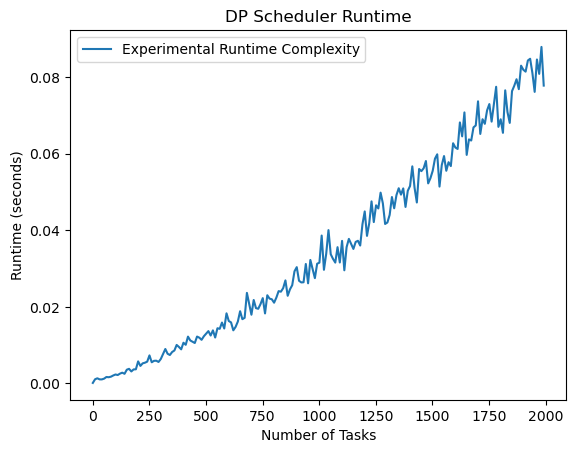

In [140]:
plotting (generate_test_cases_random_input)

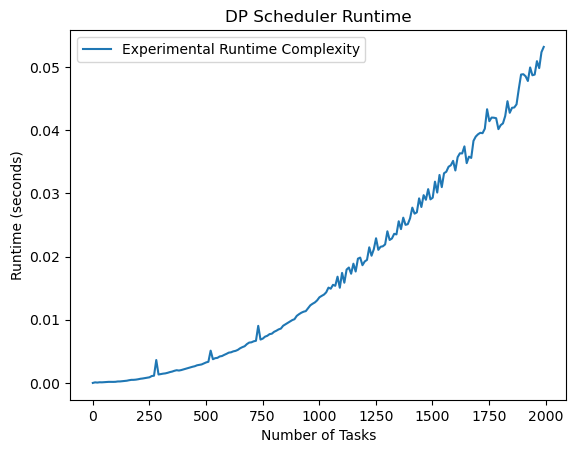

In [143]:
plotting(generate_test_cases_all_fixed_task_input)

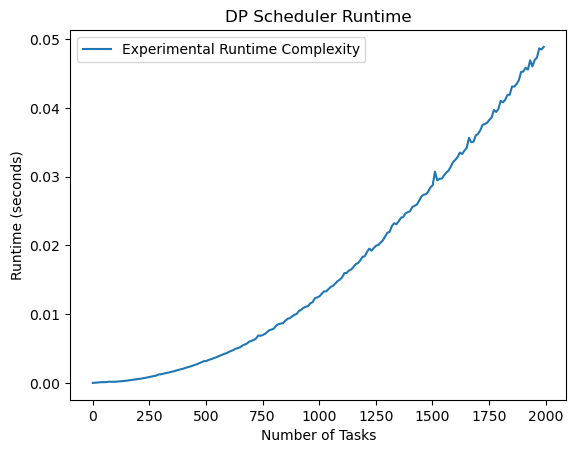

In [144]:
plotting(generate_test_cases_no_fixed_task_input)

## 2.1. Greedy - Time complexity

In [153]:
import time
import numpy as np
import matplotlib.pyplot as plt

def plotting_Greedy(input_type):
    avg_runtime = []
    experiments = 20
    input_size = list(range(1, 2000, 10))
    for size in input_size:
        runtime = []
        for i in range(experiments):
            test_cases = input_type(size)
            greedy_scheduler = Greedy(test_cases, 24*60)
            start_time = time.time()
            greedy_scheduler.calculate_utility()
            intervals_schedule = greedy_scheduler.dynamic_programming_intervals()
            greedy_scheduler.greedy_algorithm_schedule(intervals_schedule)
            end_time = time.time()
            runtime.append (end_time - start_time)
        avg_runtime.append(sum(runtime)/len(runtime))


    plt.plot(input_size, avg_runtime, label = "Experimental Runtime Complexity")
    plt.title("Greedy Scheduler Runtime")
    plt.xlabel("Number of Tasks")
    plt.ylabel("Runtime (seconds)")
    plt.legend()
    plt.show()

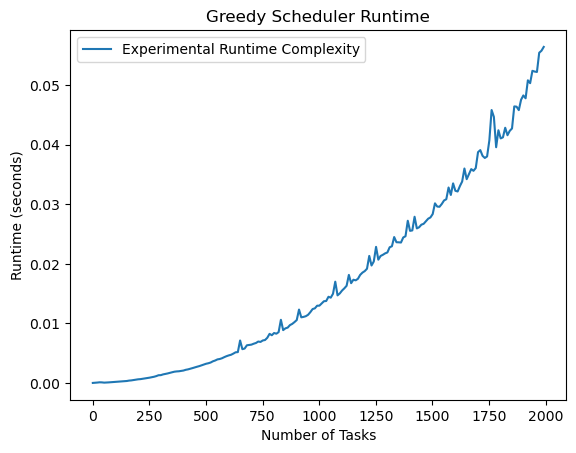

In [154]:
plotting_Greedy (generate_test_cases_random_input)

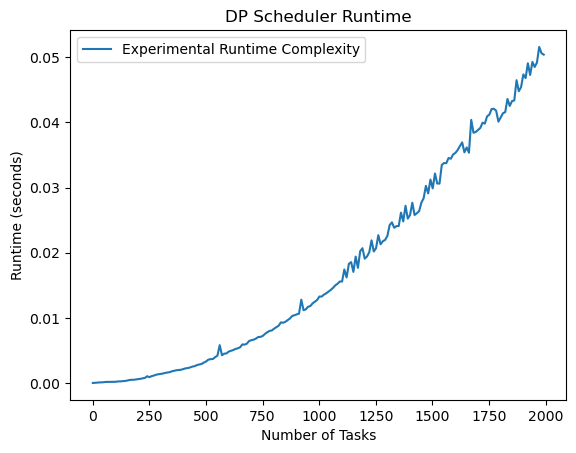

In [148]:
plotting_Greedy (generate_test_cases_all_fixed_task_input)

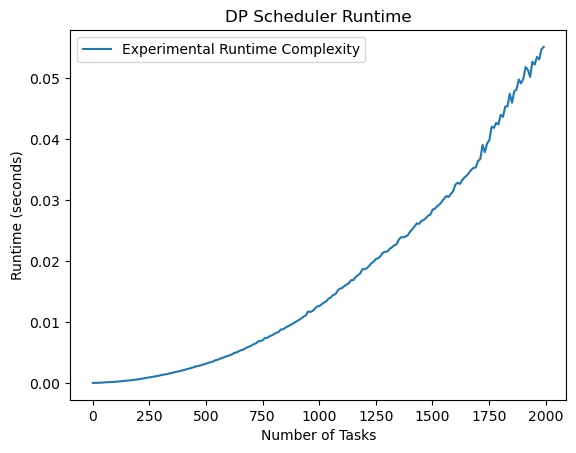

In [149]:
plotting_Greedy (generate_test_cases_no_fixed_task_input)

# LBA1 Code

In [162]:
import random, copy, math


class Task:
    """
    A class to represent a task
    """

    def __init__(self, id, description, duration, fixed, dependencies, start_time):
        """
        Constructor for the Task class

        Parameters
        ----------
        id: int
            The id of the task
        description: str
            The description of the task
        duration: int
            The duration of the task in minutes
        fixed: bool
            Whether the task is fixed or not
        dependencies: list
            A list of IDs of tasks that the 
                given task is dependent on
        start_time: float
            The start time of the task in format of hours. 
                If start time is at 14:30, the start time is 14.5
        utility: int
            The priority value of the task. 
            Initialized at 0. Will be calculated dynamically later.
        current_status: str
            The current status of the task. Initialized at "N". 
            Will be updated dynamically later to either "I" or "COMPLETED". 
        """

        self.id = id
        self.description = description
        self.duration = duration
        self.fixed = fixed
        self.dependencies = dependencies
        self.start_time = start_time
        self.current_status = "N"
        self.utility = 0


    def __lt__(self, other):
        """
        Comparator
        Parameters
        ----------
        other: Task object or int
        Returns
        ----------
        bool
            True if the priority value of the 
                current task is less than the other task
        """

        if type(other) == int:
            return self.utility < other
        elif type(other) == Task:
            return self.utility < other.utility
    def __str__(self):
        return f"Task {self.id}: {self.description}, \
        Duration: {self.duration} mins, Fixed: {self.fixed}, \
    Dependencies: {self.dependencies}, Start Time: {self.start_time}"

In [163]:

class TaskScheduler:
    """
    A class to represent a task scheduler

    Methods
    -------

    scheduler_run(init_time, print_schedule=True)
        Schedule tasks based on fixed and flexible priorities
    convert_time(time)
        Converts time input into minutes
    calculate_utility()
        Calculates the priority value of each task in the task scheduler
    remove_dependency(dependency_id)
        Removes the completed task with dependency_id from the dependencies of all tasks
    task_wo_dependencies()
        Find tasks without dependencies and add them to their respective priority queues
    not_scheduled()
        Checks if there are any unscheduled tasks
    format_time(time)
        Formats the time in the format of hours and minutes (HH:MM)
    print_schedule(total_time)
        Prints out the task schedules
    print_completed_task(task, current_time)
        Prints the completed task
    """

    def __init__(self, tasks):
        """
        Constructor for the TaskScheduler class

        Parameters
        ----------
        tasks: list
            A list of Task objects
        fixed_priority_queue: MaxHeap object
            A max heap priority queue to store the fixed tasks
        flexible_priority_queue: MaxHeap object
            A max heap priority queue to store the flexible tasks        
        """

        self.tasks = tasks
        self.order = []
        self.fixed_priority_queue = MaxHeap()
        self.flexible_priority_queue = MaxHeap()
        


    def print_self(self):
        """
        Prints the tasks in the task scheduler and if they still have dependencies.

        Parameters
        ----------
        None

        Returns
        ----------
        None
        """

        print("Tasks To Be Done:")
  
        for t in self.tasks:
            print(f"➡️'{t.description}', duration = {t.duration} mins.")
            if len(t.dependencies) > 0:
                print(f"\t ⚠️ This task depends on {t.dependencies}")
        print()
    def convert_time(self, time):
        #This converts time input into minutes
       
        if isinstance(time, int):
            time_in_minutes = time * 60
            time_in_float = float(time_in_minutes)
            return time_in_float
        else:
            hours, minutes = map(int, time.split(':'))
            time_in_minutes = hours * 60 + minutes
            time_in_float = float(time_in_minutes)
            return time_in_float


    def calculate_utility(self):
        '''
        Calculates the priority value of each task in the 
            task scheduler and updates them

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''
        


        for task in self.tasks:
            if task.fixed:
                task.utility = 1/self.convert_time(task.start_time) * (24*60) 
                #we just use the converted time in minutes. 
                #Lesser minutes correlates to higher priority
                
            else:
                task.utility = math.exp(-len(task.dependencies)) * task.duration 
                #As explained in the utility analysis,
                #we prioritize tasks with lesser number 
                #of task dependencies, but with higher duration


    def remove_dependency(self, dependency_id):
        '''
        Removes the completed task with dependency_id from the dependencies of all tasks

        Parameters
        ----------
        dependency_id: int
            The id of the completed task

        Returns
        ----------
        None
        '''
        for task in self.tasks:
            
            if dependency_id in task.dependencies:
                task.dependencies.remove(dependency_id)

    def task_wo_dependencies(self):
        '''
        Find tasks without dependencies and add 
            them to their respective priority queues

        Parameters
        ----------
        None

        Returns
        ----------
        None
        '''

        for task in self.tasks:

            # if the task has no dependencies and has not started yet
            if task.current_status == "N" and not task.dependencies:
                # Update current_status of the task
                task.current_status = "I"

                if task.fixed:
                    self.fixed_priority_queue.heappush(task)
                else:
                    self.flexible_priority_queue.heappush(task)

    def not_scheduled(self):
        '''
        Checks if there are any unscheduled tasks
        This will be used as our termination conditioin: 
        ~~~~ This is very helpful to avoid runnning into an infinite loop ~~~~
        Parameters
        ----------
        None

        Returns
        ----------
        bool
            True:  if there is at least one unscheduled task
            False: if all tasks are scheduled
        '''
        return any([task.current_status == 'N' for task in self.tasks])

    def format_time(self, time):
        '''
        Formats the time in the format of hours and minutes (HH:MM)

        Parameters
        ----------
        time: int
            The time in minutes

        Returns
        ----------
        str
            Time in format of hh:mm
        '''

        return f"{int(time)//60}h{int(time)%60:02d}"
    
    def scheduler_run(self, init_time, print_schedule=True):
        
        current_time = init_time
        self.calculate_utility()

        
        task = None

        #this is where I improved the code, we need to check if there is still task\
        in either of the priority queues or not
        while self.not_scheduled() or self.flexible_priority_queue.heap or self.fixed_priority_queue.heap:
            self.task_wo_dependencies() #gets tasks without dependencies

            if self.fixed_priority_queue.heap:
                #this checks if fixed_priority_queue is empty or not
                next_fixed_task = self.fixed_priority_queue.peek() 
                #checks the next fixed task
                next_flexible_task = self.flexible_priority_queue.peek() \
                if self.flexible_priority_queue.heap \
                else None #checks next flexible task
                remaining_time = self.convert_time(next_fixed_task.start_time) - current_time 
                #finds the time gap to fit in a fixed_task
                if next_flexible_task and \
                ( next_flexible_task.duration <= remaining_time): 
                    #checks if you can accomplish a flexible task within that time gap
                    task = self.flexible_priority_queue.heappop()
                else: #if not, just do the fixed task 
                      # ---> you may even have extra time to chill
                    task = self.fixed_priority_queue.heappop()

            else: #if we don't have fixed tasks anymore, 
                  #we just deal only with flexible tasks
                task = self.flexible_priority_queue.heappop()
            
            current_time += task.duration  # Update current_time.
            self.order.append(task.id)

            task.current_status = "COMPLETED" #update task's status
            
            
            self.remove_dependency(task.id) 
                #remove dependency from every task since it's completed
          
        total_time = current_time - init_time
        if print_schedule:
            self.print_schedule(total_time)
        


    def print_schedule(self, total_time):
        '''
        Prints out the task schhdules 
        '''
        
        print("Running the task scheduler:\n")

        current_time = init_time

        for task_id in self.order:
            task = next((t for t in self.tasks if t.id == task_id), None)
            if task:
                current_time = self.print_completed_task(task, current_time)

        print(
            f"\n🏁 Completed all planned tasks in \
            {int(total_time)//60}h{int(total_time)%60:02d}min!")



    def print_completed_task(self, task, current_time):
        '''
        Prints the completed task

        Parameters
        ----------
        task: Task object
            The completed task

        Returns
        ----------
        None
        '''

        if task.fixed: 
            current_time = self.convert_time(task.start_time)
        

        print(f"🕰t={self.format_time(current_time)}")
        print(
            f"\tstarted '{task.description}' for {task.duration} mins.")
        current_time += task.duration
        print(
            f"\t✅ t={self.format_time(current_time)}, completed  \
            {task.description}! with priority {task.utility}")

        task.current_status = "COMPLETED"
        # remove the completed task from the dependencies of other tasks
        self.remove_dependency(task.id)

        return current_time


In [ ]:
import random
from datetime import timedelta

def generate_test_cases_random_input_LBA(n):
    """
    Generates a list of n test cases for task scheduling.

    Each task is represented as a dictionary with the following keys:
    - 'id': a unique identifier for the task.
    - 'description': a string describing the task.
    - 'duration': the duration of the task in minutes
    - 'dependencies': a list of task ids that this task depends on.
    - 'fixed': a boolean indicating whether the task is flexible.
    - 'start_time': the start time of the task in minutes past midnight if fixed = True. Otherwise None

    The tasks are generated with random durations up to 60 minutes, random dependencies,
    and random flexibilities. The start times are calculated to ensure that they do not overlap
    and that all tasks can be finished within 24 hours.

    Returns:
        A list of dictionaries representing the tasks.
    """
    tasks = []
    ratio = random.randint(0, n+1) #this is a random ratio of fixed tasks vs flexible tasks in the task list
    fixed_ids = random.sample(range(0, n+1), ratio) #create a random list of fixed task id with size = ratio

    task_ids = list(range(0, n+1))
    activities = ['Cooking Lunch', 'Napping', 'CS110 Pre-Work', 'CS110 Class',
                  'Walking', 'Hiking', 'Internship Applications', 'Civic Project']


    for task_id in task_ids:
        activity_ = random.choice(activities)
        duration_ = random.randint(1, 60)
        dependencies_ = random.sample(task_ids[:task_id], k=random.randint(0, task_id)) if task_id > 0 else []
        fixed_ = True if task_id in fixed_ids else False 
        #To ensure that when fixed = True then start_time = random_time, and if fixed = False then start_time = None
        random_time = random.randint(1, 23*60)
        start_time_ = random_time if task_id in fixed_ids else None
        task = Task(id=task_id, description=activity_, duration=duration_, dependencies=dependencies_, fixed=fixed_,
        start_time=start_time_)
        tasks.append(task)

    return tasks

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

def plotting_LBA(input_type):
    avg_runtime = []
    experiments = 20
    input_size = list(range(1, 2000, 50))
    for size in input_size:
        runtime = []
        for i in range(experiments):
            test_cases = input_type(size)
            scheduler = TaskScheduler(test_cases)
            start_time = time.time()
            scheduler.scheduler_run(init_time = 7*60, print_schedule=False)
            end_time = time.time()
            runtime.append (end_time - start_time)
        avg_runtime.append(sum(runtime)/len(runtime))


    plt.plot(input_size, avg_runtime, label = "Experimental Runtime Complexity")
    plt.title("Task Scheduler Runtime")
    plt.xlabel("Number of Tasks")
    plt.ylabel("Runtime (seconds)")
    plt.legend()
    plt.show()
plotting_LBA(generate_test_cases_random_input_LBA)

# Display on the same graph

In [ ]:
combine = plotting_LBA(generate_test_cases_random_input) + plotting (generate_test_cases_random_input) + plotting_Greedy (generate_test_cases_random_input)
show(combine)                                                                                                                   